In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from dataclasses import dataclass, field
from typing import Callable, Optional
from copy import copy
from itertools import count
from scipy.optimize import minimize
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
MIN_LINK_CAPACITY = 5
MAX_LINK_CAPACITY = 20
MIN_ALLOCATION = 1

MIN_FLOW_SPEED = 5
MAX_FLOW_SPEED = 30

NUM_LINKS = 2
NUM_FLOWS = 3

def random_link_capacity() -> int:
    return random.randint(MIN_LINK_CAPACITY, MAX_LINK_CAPACITY)

def random_transmission_rate() -> int:
    return random.randint(MIN_FLOW_SPEED, MAX_FLOW_SPEED)

In [3]:
class Link:
    def __init__(self, flows_passing_through: list[int]):
        self.flows_passing_through = flows_passing_through
        self.capacity: int = random_link_capacity()
        self.set_equal_allocations()
        
        # Filled by parent structure
        self.current_rates: dict[int, int] = {}
        
    def set_equal_allocations(self):
        self.allocations = {flow_num: self.capacity // len(self.flows_passing_through) for flow_num in self.flows_passing_through}
    
    
    def validate_allocations(self):
        if sum(self.allocations.values()) > self.capacity:
            raise ValueError("Impossible allocations detected")
            
    def transmission_rate_of(self, flow_num: int) -> Optional[float]:
        if flow_num not in self.flows_passing_through:
            return None
        
        return self.allocations[flow_num]

    def remaining_allocation_resources(self):
        return self.capacity-sum(self.allocations.values())
    
    def runtime(self):
        saturated_flows: list[int] = []
        previous_rates = { flow_num: 0 for flow_num in self.flows_passing_through }
        
        free_resources = 0
        while True:    
            # Detect flow saturation
            speed_differences = {
                flow_num: self.current_rates[flow_num] - previous_rates[flow_num]
                for flow_num in previous_rates.keys()
            }
            
            logger.info("differences %r", speed_differences)
            logger.info("allocations %r", self.allocations)
            logger.info("remaining resources %r", self.remaining_allocation_resources())
            for flow_num in speed_differences:
                if speed_differences[flow_num] == 0 and flow_num not in saturated_flows:
                    logger.info(f"Flow {flow_num} saturation detected")
                    saturated_flows.append(flow_num)
                    unused_allocation = self.allocations[flow_num] - self.current_rates[flow_num]
                    self.allocations[flow_num] -= unused_allocation
                    free_resources += unused_allocation
                    
            if len(saturated_flows) == len(self.flows_passing_through):
                logger.info("ALL FLOWS SATURATED")
                break
                    
            # Give more resources to not saturated flows
            resources_to_transfer_for_each_flow = free_resources // len([flow_num for flow_num in self.flows_passing_through if flow_num not in saturated_flows])
            if resources_to_transfer_for_each_flow > 0:
                for flow_num in self.flows_passing_through:
                    if flow_num not in saturated_flows:
                        logger.info(f"Transferring {resources_to_transfer_for_each_flow} capacity to flow {flow_num}")
                        self.allocations[flow_num] += resources_to_transfer_for_each_flow
                        free_resources -= resources_to_transfer_for_each_flow
            self.validate_allocations()
            
            previous_rates = copy(self.current_rates)
            yield False
            # Hand control back to the network
            # to calculate new transmission speeds
            
        while True:
            yield True


class Flow:
    def __init__(self):             
        self.max_transmission_rate: int = random.randint(MIN_FLOW_SPEED, MAX_FLOW_SPEED)
        # satisfaction_function: Callable[[float], float]


@dataclass
class Network:
    links: list[Link]
    flows: list[Flow]
    global_max_flow_speed: int = 1
    
    def get_speed_of(self, flow_num: int):
        network_bandwidth = min(
            filter(lambda x: x is not None, [link.transmission_rate_of(flow_num) for link in self.links])
        )
        max_rate = self.flows[flow_num].max_transmission_rate
        return min(network_bandwidth, max_rate, self.global_max_flow_speed)
        
    def calculate_transmission_rates(self):
        rates = [self.get_speed_of(index) for index in range(len(self.flows))]
        return rates
    
    def propagate_transmission_rates(self):
        rates = self.calculate_transmission_rates()
        
        for link in self.links:
            for flow_id, rate in enumerate(rates):
                if flow_id in link.flows_passing_through:
                    link.current_rates[flow_id] = rate

    def calculate_utilisation(self) -> float:
        return sum(self.calculate_transmission_rates())
                    
    def format_transmission_rates(self):
        rates = self.calculate_transmission_rates()
        
        return " ".join([ f"{rate}/{flow.max_transmission_rate}" for rate, flow in zip(rates, self.flows) ])

In [8]:
n = Network(
    links=[
        Link(flows_passing_through=[0,1]),
        Link(flows_passing_through=[2,1]),
        Link(flows_passing_through=[0,2]),
    ],
    flows=[Flow(), Flow(), Flow()]
)


def wellness(allocations, network: Network) -> float:
    num_of_parameters = sum(len(l.flows_passing_through) for l in network.links)
    n.global_max_flow_speed = float('inf')   
    if len(allocations) != num_of_parameters:
        raise ValueError("Number of possible allocations does not match the number of parameters")
        
    allocation_iterator = iter(allocations)
    for link in network.links:
        for i in link.allocations:
            link.allocations[i] = next(allocation_iterator)
    
        sum_of_allocations = sum(link.allocations.values())
        for i in link.allocations:
            link.allocations[i] = link.allocations[i] * link.capacity // sum_of_allocations
            
        # print(link.capacity, link.allocations)
        link.validate_allocations()
        
    return n.calculate_utilisation()
# wellness([1,1,1,1,1,1], n)
solver_solution = minimize(wellness, [1,1,1,1,1,1], args=(n,))
solver_solution

      fun: 11.0
 hess_inv: array([[2.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.03655909e-13, 0.00000000e+00],
       [1.00000000e+00, 2.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.03655909e-13, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [3.03655909e-13, 3.03655909e-13, 0.00000000e+00, 0.00000000e+00,
        3.03766931e-13, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00]])
      jac: array([-67108864., -67108864.,         0.,         0.,         0.,
               0.])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 190
      nit: 1
     njev: 26
   status: 2
  success: False
        x: array([1.00002039, 1.00002039, 1.     

In [9]:
# n = Network(
#     links=[
#         Link(flows_passing_through=[0,1]),
#         Link(flows_passing_through=[2,1]),
#         Link(flows_passing_through=[0,2]),
#     ],
#     flows=[Flow(), Flow(), Flow()]
# )

n.global_max_flow_speed = 1

flow_rates_plot = [[] for _ in range(len(n.flows))]
link_resources_plot = [[] for _ in range(len(n.links)) ]
simulation_steps = []

runtimes = [link.runtime() for link in n.links]  
for simulation_step in count():
    simulation_steps.append(simulation_step)
    n.propagate_transmission_rates()
    logger.info("# Transmission rates %s", n.format_transmission_rates())
    
    
    rates = n.calculate_transmission_rates()
    for flow_num, rate in enumerate(rates):
        flow_rates_plot[flow_num].append(rate)
        
    for link_num in range(len(n.links)):
        link_resources_plot[link_num].append(n.links[link_num].remaining_allocation_resources())
    
    finished_running = []
    for link_num, runtime in enumerate(runtimes):
        logger.info(f"## Link {link_num}")
        finished_running.append(next(runtime))
        
    logger.info("")
    
    if all(finished_running):
        break

    n.global_max_flow_speed += 1
    
print("ALL LINKS FINISHED RUNNING")
print("# Transmission rates", n.format_transmission_rates())
print("# Utilisation", n.calculate_utilisation())

INFO:__main__:# Transmission rates 1/20 1/13 1/29
INFO:__main__:## Link 0
INFO:__main__:differences {0: 1, 1: 1}
INFO:__main__:allocations {0: 2.0, 1: 2.0}
INFO:__main__:remaining resources 2.0
INFO:__main__:## Link 1
INFO:__main__:differences {2: 1, 1: 1}
INFO:__main__:allocations {2: 9.0, 1: 9.0}
INFO:__main__:remaining resources 0.0
INFO:__main__:## Link 2
INFO:__main__:differences {0: 1, 2: 1}
INFO:__main__:allocations {0: 6.0, 2: 5.0}
INFO:__main__:remaining resources 1.0
INFO:__main__:
INFO:__main__:# Transmission rates 2.0/20 2.0/13 2/29
INFO:__main__:## Link 0
INFO:__main__:differences {0: 1.0, 1: 1.0}
INFO:__main__:allocations {0: 2.0, 1: 2.0}
INFO:__main__:remaining resources 2.0
INFO:__main__:## Link 1
INFO:__main__:differences {1: 1.0, 2: 1}
INFO:__main__:allocations {2: 9.0, 1: 9.0}
INFO:__main__:remaining resources 0.0
INFO:__main__:## Link 2
INFO:__main__:differences {0: 1.0, 2: 1}
INFO:__main__:allocations {0: 6.0, 2: 5.0}
INFO:__main__:remaining resources 1.0
INFO:__ma

ALL LINKS FINISHED RUNNING
# Transmission rates 2.0/20 2.0/13 9.0/29
# Utilisation 13.0


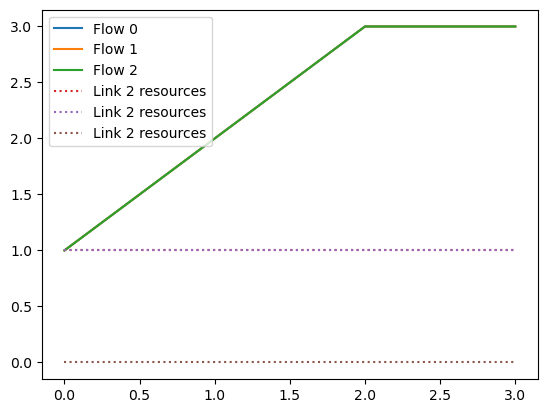

In [6]:
for flow_num, flow_data in enumerate(flow_rates_plot):
    plt.plot(flow_data, label=f"Flow {flow_num}")

for link_num, resources in enumerate(link_resources_plot):
    plt.plot(resources, linestyle='dotted', label=f"Link {flow_num} resources")
    
plt.legend(loc="upper left")
plt.show()